In [188]:
import pandas as pd
import pymysql
db_info = pymysql.connect(user='root', passwd='root',host='localhost',port=3306, db='test')
cursor = db_info.cursor()

In [189]:
def user_log_data():
    cursor.execute("SELECT * FROM user_log")

    result = []
    for c in cursor:
        res = dict()
        res['reg_time'] = c[1]
        res['user_id'] = c[2]
        res['book_id'] = c[3]
        result.append(res)
    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)


def book_data():
    cursor.execute("SELECT * FROM book")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[0]
        res['category_id'] = c[4]
        result.append(res)

    return pd.DataFrame(result)


def user_category_data():
    cursor.execute("SELECT * FROM user_category")

    result = []
    for c in cursor:
        res = dict()
        res['user_id'] = c[1]
        res['user_category_id'] = c[2]
        result.append(res)

    return pd.DataFrame(result)


def review_data():
    cursor.execute("SELECT * FROM review")

    result = []
    for c in cursor:
        res = dict()
        res['book_id'] = c[5]
        res['user_id'] = c[4]
        res['rank'] = c[1]
        res['reg_time'] = c[3]
        res['content'] = c[2]
        result.append(res)

    return pd.DataFrame(result).sort_values(by='reg_time',ascending=False).drop_duplicates(['user_id','book_id'],keep='first').reset_index(drop=True)

In [190]:
user_log = user_log_data()
user_category = user_category_data()
book = book_data()
review = review_data()

In [191]:
from sklearn.preprocessing import MultiLabelBinarizer

user_id =1 

user_category['user_category_id'] = user_category['user_category_id'].astype(str)
user_cate = user_category.groupby('user_id').agg(lambda x: ' '.join(set(x)))
user_cate['user_category_id'] = user_cate['user_category_id'].str.split(' ')


cate_list = book['category_id'].unique()
for cate in cate_list:
    user_cate['c_' + str(cate)] = 0
    
mlb = MultiLabelBinarizer()
user_cate[user_cate.columns[1:]] = mlb.fit_transform(user_cate['user_category_id'])
user_cate.drop('user_category_id',axis=1, inplace=True)

que = f'user_id=={user_id}'

if(len(user_log.query(que)) != 0 and len(review.query(que)) != 0):
    data1 = pd.merge(user_log[["book_id", "user_id"]],
                     review, how="left", on=["book_id", "user_id"])
    data1['content'].fillna('', inplace=True)
    data1['content'] = data1['content'].str.replace(
        pat=r'[^A-Za-z0-9가-힣 ]', repl=r'', regex=True).str.strip()
    data1['rank'].fillna(int(data1['rank'].mean()), inplace=True)
    data1 = pd.merge(data1, book, on="book_id")

    user_see_cate = data1.groupby(['user_id', 'category_id'])[
        'rank'].mean().unstack().fillna(0)
    user_cate = pd.concat([user_cate, user_see_cate], axis=1).fillna(0)

if(len(review.query(que)) != 0):
    # 리뷰 데이터 tf idf
    tfidf = TfidfVectorizer(stop_words='english', max_features=300)
    tfidf_matrix = tfidf.fit_transform(data1['content'])
    tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),
                              index=data1['user_id']).reset_index()
    tfidf_g_data = tfidf_data.groupby('user_id').mean()
    user_cate = pd.concat([user_cate, tfidf_g_data], axis=1).fillna(0)

In [192]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15,random_state=0)
pca.fit(user_cate)
pca_samples = pca.transform(user_cate)
ps = pd.DataFrame(pca_samples, index=user_cate.index)

In [193]:
pca.explained_variance_ratio_.sum()

0.755836498315772

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')

In [168]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []

for i in range(25, 30):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ps)
    scores.append(silhouette_score(ps, kmeans.labels_))


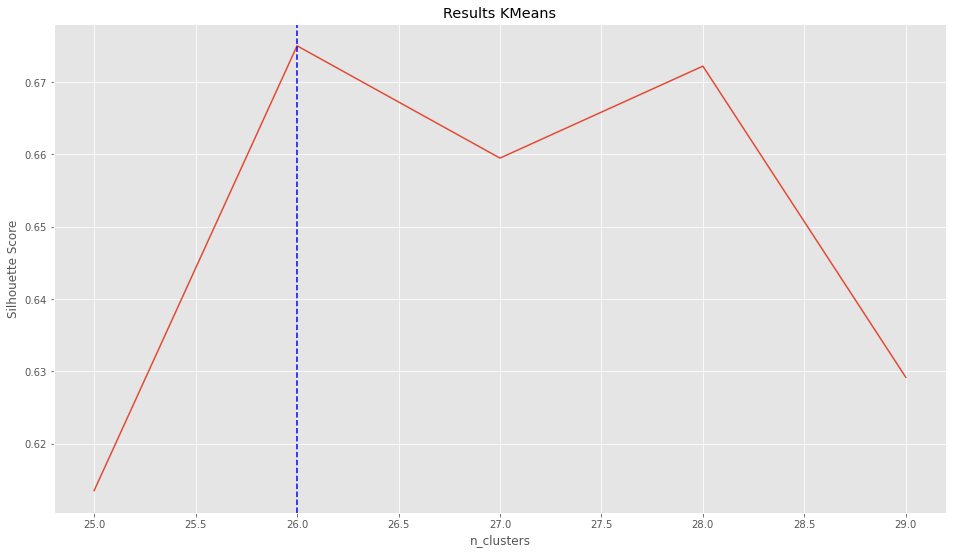

In [171]:
plt.plot(range(25, 30), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=26, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

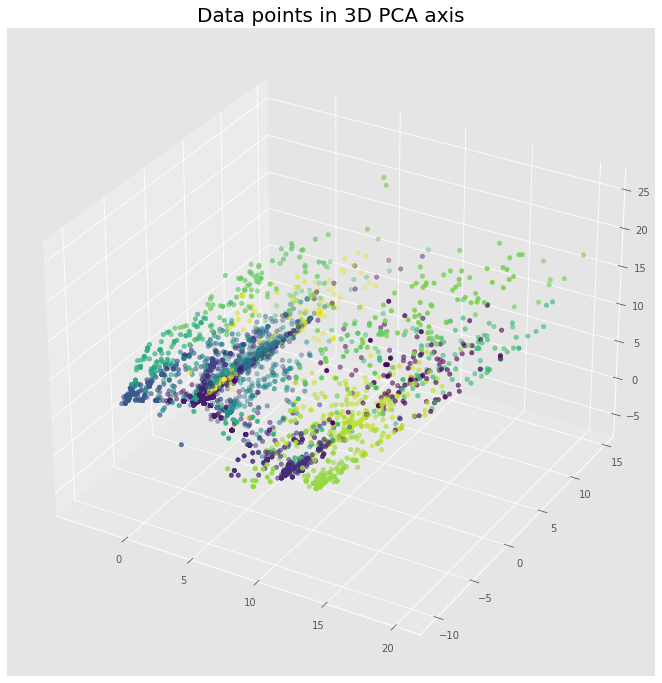

In [172]:
kmeans = KMeans(n_clusters=26, random_state=0)
kmeans.fit(ps)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(ps[0], ps[2], ps[1], c=kmeans.labels_)

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [182]:
pred = kmeans.predict(ps.loc[1,:].to_frame().T)
user_cate['cluster'] = kmeans.labels_
user_cate_cluster = user_cate[user_cate['cluster']==pred[0]].drop('cluster',axis=1)

In [183]:
user_cate['cluster'].value_counts()

2     5505
3     2101
7     1769
4     1363
6     1314
5     1219
9     1081
10    1028
11    1019
13    1019
8      930
12     834
1      765
15     714
14     671
18     610
25     427
21     380
23     164
16     155
22     150
24     150
19     138
0      129
17     115
20      88
Name: cluster, dtype: int64

In [199]:
user_log_my = user_log[user_log['user_id'].isin(user_cate_cluster.index)]
user_my_re = pd.merge(user_log_my[["book_id", "user_id"]],
                     review, how="left", on=["book_id", "user_id"])
user_my_re_g = user_my_re.groupby(["book_id", "user_id"])["rank"].mean().reset_index()
user_my_re_g = pd.merge(user_my_re_g, user_cate,on="user_id")
# user_cate_my = user_category.query("user_id==1")


In [213]:
user_my_re_g

,book_id,user_id,rank,c_1,c_74,c_170,c_336,c_351,c_517,c_656,...,290,291,292,293,294,295,296,297,298,299
0,2,1,10,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
1,69,1,10,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
2,104,1,10,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
3,150,1,10,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
4,221,1,10,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,2584,2394,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2117,3173,2394,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2118,3606,2394,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2119,6192,2394,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [251]:
user_dump = pd.get_dummies(user_my_re_g['user_id'], prefix='u')
book_dump = pd.get_dummies(user_my_re_g['book_id'], prefix='b')
all_data = pd.concat([user_dump, book_dump,
                     user_my_re_g.drop(['book_id','user_id'],axis=1)], axis=1)

In [222]:
a = pd.DataFrame(user_dump.values, columns = user_dump.columns)

In [262]:
my_test = pd.concat([user_dump, book_dump,
                     user_my_re_g.drop(['book_id','user_id','rank'],axis=1)], axis=1)
my_test = my_test[my_test["u_1"] != 1].reset_index(drop=True)
my_test[my_test.columns[my_test.columns.to_series().str.contains("u_").fillna(False)]] = 0
my_test["u_1"] = 1
my_test["rank"] = 0

In [263]:
dump_svmlight_file(my_test.drop("rank",axis=1).values,my_test["rank"].values, "test.txt")

,u_1,u_9,u_13,u_14,u_70,u_74,u_76,u_81,u_82,u_157,...,290,291,292,293,294,295,296,297,298,299
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
5,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
6,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
7,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
8,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0
9,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.026852,0.013613,0.0,0.0,0.0,0.0,0.0


In [212]:
not_books = book[~book['book_id'].isin(user_log_my["book_id"].unique())]
not_books['user_id'] = 1

# user_my_test =

,book_id,category_id
0,1,1
2,3,1
5,6,1
6,7,1
8,9,1
...,...,...
14994,14995,112011
14995,14996,112011
14996,14997,112011
14997,14998,112011


In [209]:
from sklearn.model_selection import train_test_split
y = all_data['rank']
X = all_data.drop("rank",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [259]:
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(X_train.values, y_train.values, "C:\SSAFY\python_project\S05P21A604\backend\backend\static\trainfm.txt")

OSError: [Errno 22] Invalid argument: 'C:\\SSAFY\\python_project\\S05P21A604\x08ackend\x08ackend\\static\trainfm.txt'

In [84]:
user_log_my = user_log[user_log['user_id'].isin(user_cate_tf_cluster.index)]
user_cate_my = user_category.query("user_id==1")
my_book = pd.merge(user_log_my[["book_id","user_id"]], review, on=["book_id","user_id"])
my_book_rank = my_book.pivot_table(values='rank',index='user_id',columns='book_id').fillna(0)
my_book_rank = my_book.groupby(['user_id','book_id'])["rank"].mean().unstack().fillna(0)
not_books = book[~book['book_id'].isin(user_log_my["book_id"].unique())]
not_books = not_books[not_books['category_id'].isin(user_log_my["book_id"].unique())]
user_cate_my

,user_id,user_category_id
0,1,74
1,1,798
2,1,112011


In [38]:
my_book_rank[not_books.to_list()] = 0

KeyboardInterrupt: 

In [213]:
cursor.close()